In [1]:
#Useful imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, asin, acos, atan
%reload_ext autoreload
%autoreload 2
plt.style.use('latex.mplstyle')

from point_configuration import PointConfiguration

0
0.001


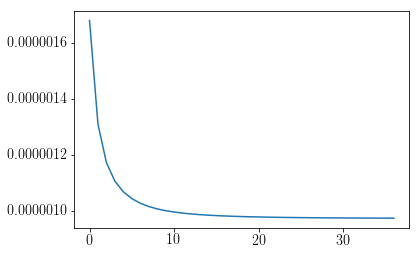

In [ ]:
from plots_cti import plot_point_sets_3d, plot_matrix
## Simulation without missing data, different noise levels.
from algorithms import reconstruct_mds
from algorithms import reconstruct_srls
from algorithms import reconstruct_acd
from distributed_mds import reconstruct_dwmds
from semidefinite import reconstruct_sdp

from basics import create_noisy_edm, get_edm

N = 10
m = 6
n = N - m
d = 3

square_size = 5

noises = np.linspace(1e-3,1e-1,1)
max_it = 1

p = PointConfiguration(N, d)

errs = np.zeros(len(noises))
errs_dict = {
    'noise':errs.copy(),
    'mds':errs.copy(),
    'acd':errs.copy(),
    'dwmds':errs.copy(),
    'sdr':errs.copy(),
    'srls':errs.copy()}


lamda = 1000
for it in range(max_it):
    print(it)
    p.set_points('random',size=square_size)
    
    for i, noise in enumerate(noises):
        print(noise)
        noisy_edm = create_noisy_edm(p.edm, noise)
        
        ## anchor-free methods 
        weights = np.ones((N,N))
        weights[range(N),range(N)] = 0.0
        x_MDS = reconstruct_mds(noisy_edm, real_points=p.points, method='geometric')
        x_ACD, fs, err_edms, err_points = reconstruct_acd(noisy_edm, weights, X_0=x_MDS.copy(), real_points=p.points)
        x_dwMDS, costs = reconstruct_dwmds(noisy_edm, X=p.points.copy(), W=weights, n=n)
        x_sdr, EDMbest = reconstruct_sdp(noisy_edm, weights, lamda, p.points)
        plt.plot(costs)
        
        plot_point_sets_3d([p.points, x_MDS, x_dwMDS],['original','MDS','dwMDS'], display_lines=True)
        
        err_noise = np.linalg.norm(p.points - p.points)
        err_MDS = np.linalg.norm(x_MDS - p.points)
        print('err_MDS  ',err_MDS)
        err_ACD = np.linalg.norm(x_ACD - p.points)
        print('err_ACD  ',err_ACD)
        err_dwMDS = np.linalg.norm(x_dwMDS - p.points)
        print('err_dwMDS',err_dwMDS)
        err_SDR = np.linalg.norm(x_sdr - p.points)
        print('err_SDR  ',err_SDR)
        errs_dict['noise'][i] += err_noise
        errs_dict['mds'][i] += err_MDS
        errs_dict['acd'][i] += err_ACD
        errs_dict['sdr'][i] += err_SDR
        errs_dict['dwmds'][i] += err_dwMDS
              
        ## anchor-methods
        ## TODO: use number of anchors
        x_SRLS = reconstruct_srls(noisy_edm, p.points, indices=range(n), weights=None)
        err_SRLS = np.linalg.norm(x_SRLS - p.points)
        errs_dict['srls'][i] += err_SRLS
        print('err_SRLS ',err_SRLS)